## Use Annotations File to find and download masks and images from Open Images V6

In [2]:
import glob
import pandas as pd
import os
import wget
import cv2
import matplotlib.pyplot as plt
import shutil 

train_mask_dir = "train_masks"
train_images_dir = "train_images"

class_table = pd.read_csv("class-descriptions-boxable.csv", header=None)
class_to_label = class_table.set_index(1).to_dict()[0] # Friendly Name to ID
label_to_class = class_table.set_index(0).to_dict()[1] # ID to Friendly Name

annotations = pd.read_csv("train-annotations-object-segmentation.csv")
image_ids = pd.read_csv("train-images-boxable-with-rotation.csv")

In [3]:
# Get the Train-0 images
train_0 = annotations[annotations.MaskPath.map(lambda x : x[0]) == '0']

In [4]:
# Get only the car masks
df = train_0[train_0.LabelName == class_to_label['Car']]

In [5]:
df.shape

(11093, 10)

In [6]:
# Choose a box that occupies between 10% and 80% of the screen 
min_perc = 10
max_perc = 80

# Helper Function to calculate the Area  occupied by a mask
def find_area(x):
    return 100*(x['BoxXMax'] - x['BoxXMin'])*(x['BoxYMax']-x['BoxYMin'])

df['Area'] = df.apply(lambda x : find_area(x), axis=1)
df = df.loc[(df['Area'] < max_perc)]
df = df.loc[(df['Area'] > min_perc)]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
# Filter to items with a predicted IoU of 100
df = df.loc[df.PredictedIoU > 0.8]

In [16]:
# Add a Nice Label Column
df['NiceLabel'] = df['LabelName'].map(label_to_class)

In [84]:
# Remove Images with multiple masks
mask_counts = df.groupby("ImageID")['MaskPath'].count().reset_index()
single_mask = mask_counts[mask_counts['MaskPath'] < 2]
df = pd.merge(df, single_mask[['ImageID']], 'inner')

In [85]:
# Copy Files nested under their own labels

for index, row in df.iterrows():
    sub_directory = os.path.join(train_mask_dir, row['NiceLabel'])
    if(not os.path.exists(sub_directory)):
        os.mkdir(sub_directory)
    
    from_path = os.path.join(train_mask_dir, row['MaskPath'])
    to_path = os.path.join(sub_directory, row['MaskPath'])
    
    shutil.copy(from_path, to_path)

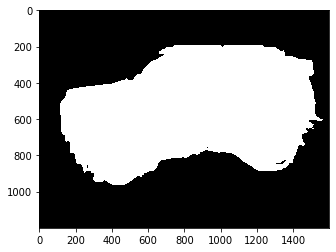

In [87]:
# Show an Example Mask

img = cv2.imread('./train_masks/Car/00012db06b98f573_m0k4j_a2075c96.png')
plt.imshow(img)

In [89]:
# Download the corresponding Images
image_ids = image_ids[['ImageID', 'OriginalURL']]

In [90]:
df_url = pd.merge(df, image_ids, 'left')

In [101]:
for index, row in df_url.iterrows():
    url = row['OriginalURL']
    
    sub_directory = os.path.join(train_images_dir, row['NiceLabel'])
    if(not os.path.exists(sub_directory)):
        os.mkdir(sub_directory, )
        
    file_extension = url.split(".")[-1] 
    wget.download(url, os.path.join(sub_directory, row['ImageID'] + "." + file_extension))


KeyboardInterrupt: 

In [96]:
os.path.splitext("hello.txt")[1]

'.txt'

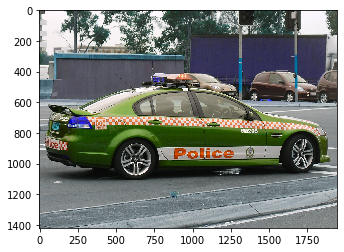

In [61]:
img = cv2.imread('./dummy.png')
plt.imshow(img)